In [1]:
import os
import sys
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

In [2]:
input_dim = 196
hidden_dim = 98
output_dim = 10


class Network_ANN(nn.Module):
    def __init__(self):
        super(Network_ANN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim, bias=False)
        self.HalfRect1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.HalfRect2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(hidden_dim, output_dim, bias=False)
        self.HalfRect3 = nn.ReLU()

    def to(self, device):
        self.device = device
        super().to(device)
        return self

    def forward(self, input):
        x = input.view(-1,input_dim)
        x = self.fc1(x)
        x = self.HalfRect1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.HalfRect2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.HalfRect3(x)
        return x

    def normalize_nn(self, train_loader):
        fc1_weight_max = torch.max(F.relu(self.fc1.weight))
        fc2_weight_max = torch.max(F.relu(self.fc2.weight))
        fc3_weight_max = torch.max(F.relu(self.fc3.weight))
        fc1_activation_max = 0.0
        fc2_activation_max = 0.0
        fc3_activation_max = 0.0

        self.eval()
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            x = inputs.float().to(self.device).view(-1,input_dim)
            x = self.dropout1(self.HalfRect1(self.fc1(x)))
            fc1_activation_max = max(fc1_activation_max, torch.max(x))
            x = self.dropout2(self.HalfRect2(self.fc2(x)))
            fc2_activation_max = max(fc2_activation_max, torch.max(x))
            x = self.HalfRect3(self.fc3(x))
            fc3_activation_max = max(fc3_activation_max, torch.max(x))
        self.train()

        self.factor_log = []
        previous_factor = 1

        scale_factor = max(fc1_weight_max, fc1_activation_max)
        applied_inv_factor = (scale_factor / previous_factor).item()
        self.fc1.weight.data = self.fc1.weight.data / applied_inv_factor
        self.factor_log.append(1/ applied_inv_factor)
        previous_factor = scale_factor

        scale_factor = max(fc2_weight_max, fc2_activation_max)
        applied_inv_factor = (scale_factor / previous_factor).item()
        self.fc2.weight.data = self.fc2.weight.data / applied_inv_factor
        self.factor_log.append(1 / applied_inv_factor)
        previous_factor = scale_factor

        scale_factor = max(fc3_weight_max, fc3_activation_max)
        applied_inv_factor = (scale_factor / previous_factor).item()
        self.fc3.weight.data = self.fc3.weight.data / applied_inv_factor
        self.factor_log.append(1 / applied_inv_factor)
        previous_factor = scale_factor


In [3]:
class Network_SNN(nn.Module):
    def __init__(self, time_window=35, threshold=1.0, max_rate=400):
        super(Network_SNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim, bias=False)
        self.HalfRect1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.HalfRect2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(hidden_dim, output_dim, bias=False)
        self.HalfRect3 = nn.ReLU()

        self.threshold = threshold
        self.time_window = time_window
        self.refractory_t = 0
        self.dt = 0.001 # second
        self.max_rate = max_rate
        self.rescale_factor = 1.0/(self.dt*self.max_rate)

    def to(self, device):
        self.device = device
        super().to(device)
        return self

    def mem_update(self, t,  operator, mem, input_spk, leak=0, refrac_end=None):
        impulse = operator(input_spk)
        
        if refrac_end is not None:
            impulse = impulse * ((refrac_end <= t).float())
            
        mem = mem + impulse + leak
        output_spk = (mem >= self.threshold).float()
        mem = mem * (1. - output_spk)
        
        if refrac_end is not None:
            refrac_end = output_spk * (t + self.refractory_t)
            
        return mem, output_spk

    def forward(self, input):
        infer, _input = input
        batch_size = _input.size(0)

        spk_input = spksum_input = torch.zeros(batch_size, input_dim, device=self.device)
        mem_post_fc1 = spk_post_fc1 = spksum_post_fc1 = torch.zeros(batch_size, hidden_dim, device=self.device)
        mem_post_fc2 = spk_post_fc2 = spksum_post_fc2 = torch.zeros(batch_size, hidden_dim, device=self.device)
        mem_post_fc3 = spk_post_fc3 = spksum_post_fc3 = torch.zeros(batch_size, output_dim, device=self.device)

        for t in range(self.time_window):
            if infer == 'Synth Test':
                _t = _input[:,t,:,:,:].view(batch_size, input_dim)
            else:
                _t = _input.view(batch_size, input_dim)
            
            spk_input = (torch.rand(_t.size(), device=self.device) * self.rescale_factor <= _t).float()
            spksum_input = spksum_input + spk_input

            mem_post_fc1 ,spk_post_fc1 = self.mem_update(t, self.fc1, mem_post_fc1, spk_input)
            spksum_post_fc1 = spksum_post_fc1 + spk_post_fc1

            mem_post_fc2, spk_post_fc2 = self.mem_update(t, self.fc2, mem_post_fc2, spksum_post_fc1)
            spksum_post_fc2 = spksum_post_fc2 + spk_post_fc2

            mem_post_fc3, spk_post_fc3 = self.mem_update(t, self.fc3, mem_post_fc3, spksum_post_fc2)
            spksum_post_fc3 = spksum_post_fc3 + spk_post_fc3
            
        outputs = spksum_post_fc3 / self.time_window
        return spksum_input, spksum_post_fc1, spksum_post_fc2, spksum_post_fc3, outputs


In [4]:
def mnist_transform():
    return transforms.Compose([transforms.Resize(14), transforms.ToTensor()])

train_batch_size = 100
test_batch_size = 128
train_dataset = torchvision.datasets.MNIST(root="D:\Dataset\mnist", train=True, download=True, transform=mnist_transform())
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

val_dataset = torchvision.datasets.MNIST(root="D:\Dataset\mnist", train=False, download=False, transform=mnist_transform())
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=test_batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 118027313.29it/s]


Extracting D:\Dataset\mnist/MNIST/raw/train-images-idx3-ubyte.gz to D:\Dataset\mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 67939256.21it/s]


Extracting D:\Dataset\mnist/MNIST/raw/train-labels-idx1-ubyte.gz to D:\Dataset\mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 39242217.23it/s]


Extracting D:\Dataset\mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to D:\Dataset\mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3138472.61it/s]


Extracting D:\Dataset\mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to D:\Dataset\mnist/MNIST/raw



In [5]:
device = torch.device("cuda:0")
learning_rate = 1
best_acc = 0  
start_epoch = 0
num_epochs = 1
acc_record = list([])
loss_train_record = list([])
loss_test_record = list([])

In [6]:
from torch.utils.data import TensorDataset, DataLoader


path = '/kaggle/input/synth-mnist/synth_mnist_14_dataset.pth'
loaded_tensors = torch.load(path)
dataset = TensorDataset(*loaded_tensors)


batch_size = 128
shuffle = True

synth_val_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

torch.Size([128, 35, 1, 14, 14]) torch.Size([128]) 

tensor(8.) 



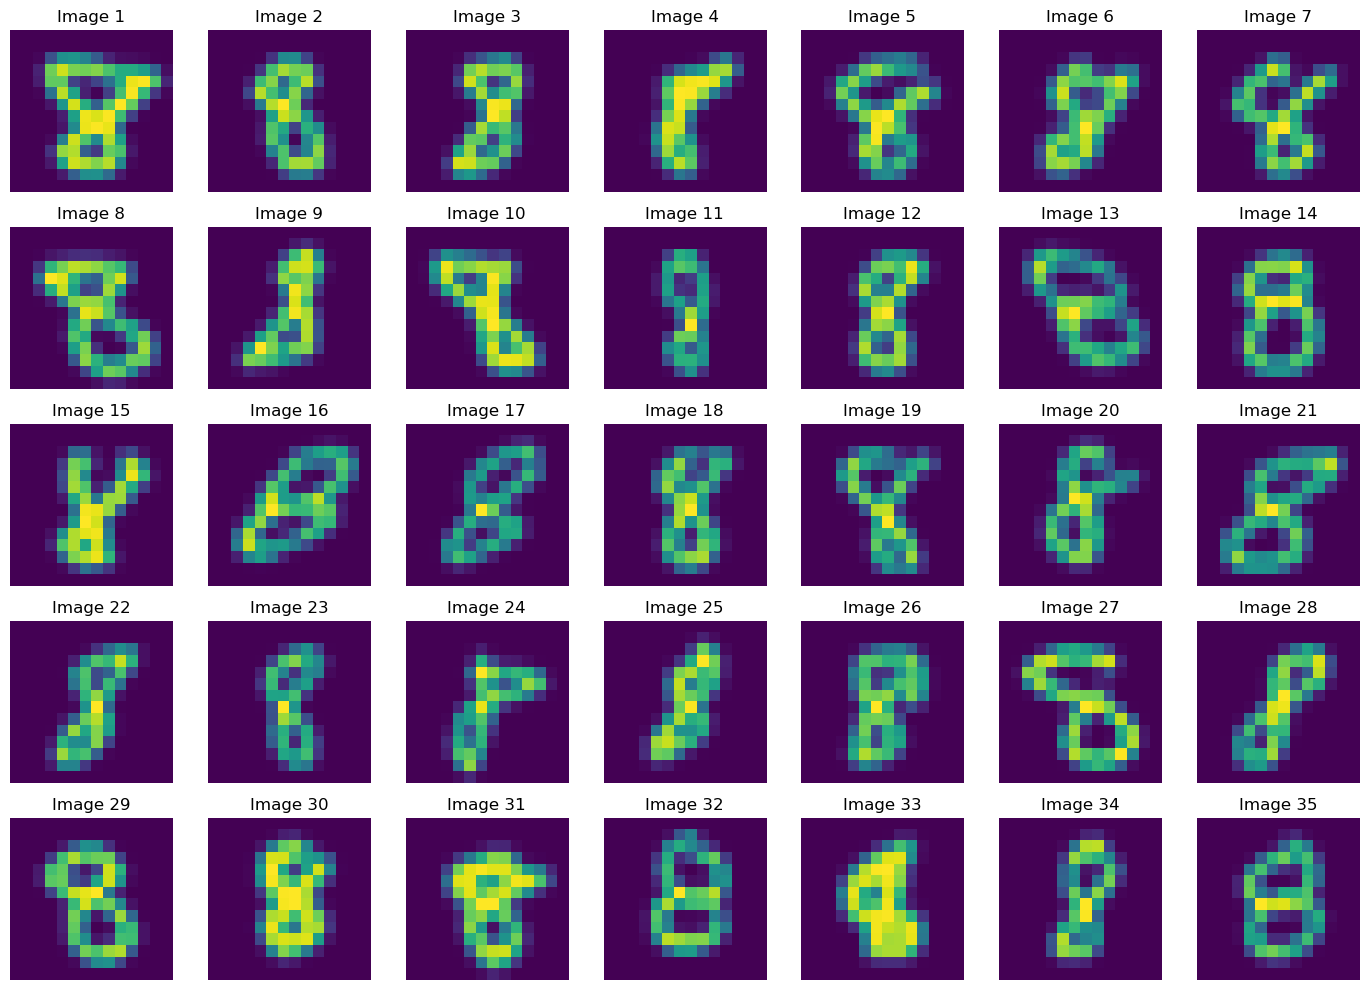

In [7]:
import matplotlib.pyplot as plt


for i, (inputs, targets) in enumerate(synth_val_loader):
    print(inputs.shape, targets.shape, '\n')
    fig, axes = plt.subplots(nrows=5, ncols=7, figsize=(14, 10))
    axes = axes.flatten()
    
    for j, (img, ax) in enumerate(zip(inputs[0], axes)):
        ax.imshow(img.squeeze(0))
        ax.axis('off')
        ax.set_title(f'Image {j+1}')
    print(targets[i], '\n')
    break

plt.tight_layout()
plt.show()

In [8]:
def evaluateSNN(SNN, ANN, loader_list=[('Ordin Test', val_loader), ('Synth Test', synth_val_loader)]):
    inp_spksum = torch.zeros((test_batch_size, input_dim)).cuda()
    fc1_spksum = torch.zeros((test_batch_size, hidden_dim)).cuda()
    fc2_spksum = torch.zeros((test_batch_size, hidden_dim)).cuda()
    fc3_spksum = torch.zeros((test_batch_size, output_dim)).cuda()

    correct = 0
    total = 0

    for split, loader in loader_list:
        for batch_idx, (inputs, targets) in enumerate(loader):
            batch_sz = inputs.size(0)
            targets = targets.to(device)
            inputs = inputs.float().to(device)
            spksum_input, spksum_1, spksum_2, spksum_3, outputs = SNN((split, inputs))

            if batch_idx != len(loader)-1:
                inp_spksum += spksum_input
                fc1_spksum += spksum_1
                fc2_spksum += spksum_2
                fc3_spksum += spksum_3

            _, predicted = outputs.max(1)
            total += float(targets.size(0))
            correct += float(predicted.eq(targets).sum().cpu().item())
        print("SNN", split, "Accuracy: %.3f" % (100 * correct / total))
        print('Input Spike-Rate:', torch.sum(inp_spksum/(test_batch_size*(len(loader)-1))).item() / input_dim)
        print('FC1 Spike-Rate:', torch.sum(fc1_spksum/(test_batch_size*(len(loader)-1))).item() / hidden_dim)
        print('FC2 Spike-Rate:', torch.sum(fc2_spksum/(test_batch_size*(len(loader)-1))).item() / hidden_dim)
        print('FC3 Spike-Rate:', torch.sum(fc3_spksum/(test_batch_size*(len(loader)-1))).item() / output_dim)
        print()


In [9]:
ANN = Network_ANN()
ANN.to(device)
print(ANN, end='\n')

optimizer = torch.optim.SGD(ANN.parameters(), lr=learning_rate)
criterion = nn.MSELoss().to(device)


for epoch in range(num_epochs):
    running_loss = 0
    start_time = time.time()
    for i, (inputs, targets) in enumerate(train_loader):
        batch_sz = inputs.size(0)
        ANN.zero_grad()
        optimizer.zero_grad()
        inputs = inputs.float().to(device)
        labels_ = torch.zeros(batch_sz, output_dim).scatter_(1, targets.view(-1, 1), 1).to(device)
        outputs = ANN(inputs)
        loss = criterion(outputs, labels_)
        running_loss += loss.cpu().item()
        loss.backward()
        optimizer.step()
        if (i+1) % 100 == 0:
            print ('Epoch [%d/%d], Step [%d/%d], Training Loss: %.5f Time elasped:%.2f s'
                  %(epoch+1, num_epochs, i+1, len(train_dataset)//train_batch_size,running_loss,time.time()-start_time))
            running_loss = 0

    correct = 0
    total = 0
    
    with torch.no_grad():
        for split, loader in [('Train', train_loader), ('Test', val_loader)]:
            for batch_idx, (inputs, targets) in enumerate(loader):
                batch_sz = inputs.size(0)            
                inputs = inputs.float().to(device)
                labels_ = torch.zeros(batch_sz, output_dim).scatter_(1, targets.view(-1, 1), 1).to(device)
                outputs = ANN(inputs)
                targets = targets.to(device)
                loss = criterion(outputs, labels_)
                _, predicted = outputs.max(1)
                total += float(targets.size(0))
                correct += float(predicted.eq(targets).sum().cpu().item())
            print("ANN", split, "Accuracy: %.3f" % (100 * correct / total))
            acc = 100. * float(correct) / float(total)
            acc_record.append(acc)


Network_ANN(
  (fc1): Linear(in_features=196, out_features=98, bias=False)
  (HalfRect1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=98, out_features=98, bias=False)
  (HalfRect2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=98, out_features=10, bias=False)
  (HalfRect3): ReLU()
)
Epoch [1/1], Step [100/600], Training Loss: 8.42613 Time elasped:3.36 s
Epoch [1/1], Step [200/600], Training Loss: 6.60149 Time elasped:4.84 s
Epoch [1/1], Step [300/600], Training Loss: 5.43557 Time elasped:6.32 s
Epoch [1/1], Step [400/600], Training Loss: 4.80754 Time elasped:7.85 s
Epoch [1/1], Step [500/600], Training Loss: 4.40718 Time elasped:9.77 s
Epoch [1/1], Step [600/600], Training Loss: 4.09928 Time elasped:11.37 s
ANN Train Accuracy: 81.167
ANN Test Accuracy: 81.180


In [10]:
SNN = Network_SNN(time_window=35, threshold=1.0)
SNN.to(device)
SNN.load_state_dict(ANN.state_dict())

print('Non-Normalized Results\n')
evaluateSNN(SNN, ANN)


ANN.normalize_nn(train_loader)
SNN = Network_SNN(time_window=35, threshold=1.0)
SNN.to(device)
SNN.load_state_dict(ANN.state_dict())

print('\n\nNormalized Results\n')
evaluateSNN(SNN, ANN)

Non-Normalized Results

SNN Ordin Test Accuracy: 78.105
Input Spike-Rate: 1.8328424570511799
FC1 Spike-Rate: 0.7479606161312181
FC2 Spike-Rate: 7.604884556361607
FC3 Spike-Rate: 5.2021339416503904

SNN Synth Test Accuracy: 85.052
Input Spike-Rate: 3.668723592952806
FC1 Spike-Rate: 1.347715105329241
FC2 Spike-Rate: 14.544707629145408
FC3 Spike-Rate: 9.536351013183594



Normalized Results

SNN Ordin Test Accuracy: 80.287
Input Spike-Rate: 1.832851487763074
FC1 Spike-Rate: 0.522819674744898
FC2 Spike-Rate: 7.295225805165816
FC3 Spike-Rate: 4.498594665527344

SNN Synth Test Accuracy: 87.478
Input Spike-Rate: 3.668953409000319
FC1 Spike-Rate: 0.9362630260233976
FC2 Spike-Rate: 13.883414132254464
FC3 Spike-Rate: 8.18304443359375



In [11]:
SNN = Network_SNN(time_window=35, threshold=1.0, max_rate=1000)
SNN.to(device)
SNN.load_state_dict(ANN.state_dict())

print('Increased Max-Rate Results\n')
evaluateSNN(SNN, ANN)

Increased Max-Rate Results

SNN Ordin Test Accuracy: 84.383
Input Spike-Rate: 4.582143978196747
FC1 Spike-Rate: 1.3884000194316009
FC2 Spike-Rate: 11.63275520169005
FC3 Spike-Rate: 5.537137985229492

SNN Synth Test Accuracy: 91.007
Input Spike-Rate: 9.171784070073342
FC1 Spike-Rate: 2.489252362932478
FC2 Spike-Rate: 22.320579061702805
FC3 Spike-Rate: 9.9918212890625

